<a href="https://colab.research.google.com/github/NabeelEhsan/BOVW/blob/main/model2/Flowers_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if we have access to a GPU
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Set up GPU to be the default device
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU is available')
else:
    device = torch.device("cpu")
    print('GPU is not available')

Default GPU Device: /device:GPU:0
GPU is available


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
import shutil
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive


/content/drive/MyDrive


In [ ]:
!unzip flower_photos.zip


Archive:  flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: flower_photos/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower_photos/daisy/10555749515_13a12a026e.jpg  
  inflating: flower_photos/daisy/10

In [ ]:

root_dir = '/content/drive/MyDrive/flower_photos'  # path of the original folder
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
test_ratio = 0.20

for class_name in classes:
    # create train and test directories for each class
    os.makedirs(os.path.join(root_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(root_dir, 'test', class_name), exist_ok=True)

    # get list of all file names for the current class
    source_dir = os.path.join(root_dir, class_name)
    all_file_names = os.listdir(source_dir)

    # shuffle file names and split into train and test sets
    random.shuffle(all_file_names)
    num_test_files = int(len(all_file_names) * test_ratio)
    test_file_names = all_file_names[:num_test_files]
    train_file_names = all_file_names[num_test_files:]

    # copy train and test files to their respective directories
    for file_name in train_file_names:
        src_path = os.path.join(source_dir, file_name)
        dest_path = os.path.join(root_dir, 'train', class_name, file_name)
        shutil.copy(src_path, dest_path)

    for file_name in test_file_names:
        src_path = os.path.join(source_dir, file_name)
        dest_path = os.path.join(root_dir, 'test', class_name, file_name)
        shutil.copy(src_path, dest_path)



In [4]:

def load_image_data(path):
    data = []
    labels = []

    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, (224, 224))
            data.append(img)
            labels.append(folder)

    return np.array(data), np.array(labels)



In [5]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors = []
    img_descriptors = []

    for i in images:
        keypoints, descriptor = sift.detectAndCompute(i, None)
        descriptors.extend(descriptor)
        img_descriptors.append(descriptor)
        
    return np.array(descriptors), img_descriptors

In [6]:
# Load the training and test datasets
path_to_train_dataset = "/content/drive/MyDrive/flower_photos/train"
path_to_test_dataset = "/content/drive/MyDrive/flower_photos/test"

train_data, train_labels = load_image_data(path_to_train_dataset)
test_data, test_labels = load_image_data(path_to_test_dataset)

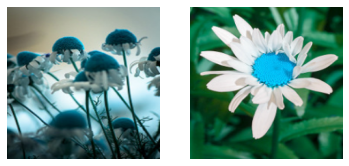

Training label: ['daisy' 'daisy']


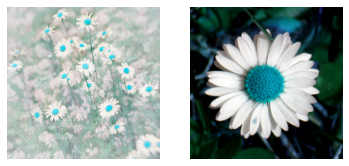

Test label: ['daisy' 'daisy']


In [7]:
# Display some sample images
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(train_data[i])
    plt.axis('off')
plt.show()
print('Training label: %s' % (train_labels[0:2],))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(test_data[i])
    plt.axis('off')
plt.show()
print('Test label: %s' % (test_labels[0:2],))

In [8]:
# Extract SIFT features from training and test images
d, img_d = extract_sift_features(train_data)
t, img_t = extract_sift_features(test_data)


In [9]:
# Cluster the feature descriptors
kmeans = KMeans(n_clusters=100)
kmeans.fit(d)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=100)

In [10]:
kmeans.cluster_centers_.shape

(100, 128)

In [11]:
# Fit 1-NN model to the feature descriptors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(kmeans.cluster_centers_)

NearestNeighbors(n_neighbors=1)

In [12]:
# Compute histograms for training images
histograms = []
for descriptors in img_d:
    # Predict visual words using 1-NN
    distances, indices = nn.kneighbors(descriptors)
    visual_words = indices.flatten()
    # Compute histogram
    histogram, _ = np.histogram(visual_words, bins=kmeans.n_clusters)
    histograms.append(histogram)

# Normalize histograms
scaler = StandardScaler()
histograms = scaler.fit_transform(histograms)


In [13]:
# Compute histograms for test images
test_histograms = []
for descriptors in img_t:
    # Predict visual words using 1-NN
    distances, indices = nn.kneighbors(descriptors)
    visual_words = indices.flatten()
    # Compute histogram
    histogram, _ = np.histogram(visual_words, bins=kmeans.n_clusters)
    test_histograms.append(histogram)

# Normalize histograms
test_histograms = scaler.transform(test_histograms)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

svm = SVC()
svm.fit(histograms, train_labels)
svm_preds = svm.predict(test_histograms)
svm_acc = accuracy_score(test_labels, svm_preds)
cm = confusion_matrix(test_labels, svm_preds)
f1 = f1_score(test_labels, svm_preds, average='weighted')
accuracy = accuracy_score(test_labels, svm_preds)

print("SVM Performance:")
print(classification_report(test_labels, svm_preds))

for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    print(f"Class {i+1}:")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positive Rate (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)




SVM Performance:
              precision    recall  f1-score   support

       daisy       0.65      0.51      0.57       126
   dandelion       0.58      0.79      0.67       179
       roses       0.58      0.43      0.49       128
  sunflowers       0.62      0.71      0.66       139
      tulips       0.50      0.43      0.46       159

    accuracy                           0.58       731
   macro avg       0.59      0.57      0.57       731
weighted avg       0.58      0.58      0.57       731

Class 1:
True Positives (TP): 64
False Positives (FP): 35
True Negatives (TN): 570
False Negatives (FN): 62
True Positive Rate (TPR): 0.5079
False Positive Rate (FPR): 0.0579
Class 2:
True Positives (TP): 141
False Positives (FP): 103
True Negatives (TN): 449
False Negatives (FN): 38
True Positive Rate (TPR): 0.7877
False Positive Rate (FPR): 0.1866
Class 3:
True Positives (TP): 55
False Positives (FP): 40
True Negatives (TN): 563
False Negatives (FN): 73
True Positive Rate (TPR): 0.4297
F

In [20]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50, random_state=20)
rf.fit(histograms, train_labels)

# Test Random Forest Classifier
rf_preds = rf.predict(test_histograms)
rf_acc = accuracy_score(test_labels, rf_preds)
cm = confusion_matrix(test_labels, rf_preds)
f1 = f1_score(test_labels, rf_preds, average='weighted')
accuracy = accuracy_score(test_labels, rf_preds)

print("Random Forest Performance:")
print(classification_report(test_labels, rf_preds))
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    print(f"Class {i+1}:")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positive Rate (TPR): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")

print("F1 Score: ", f1)
print("Accuracy: ", accuracy)


Random Forest Performance:
              precision    recall  f1-score   support

       daisy       0.52      0.43      0.47       126
   dandelion       0.51      0.70      0.59       179
       roses       0.42      0.30      0.35       128
  sunflowers       0.59      0.61      0.60       139
      tulips       0.50      0.47      0.48       159

    accuracy                           0.51       731
   macro avg       0.51      0.50      0.50       731
weighted avg       0.51      0.51      0.51       731

Class 1:
True Positives (TP): 54
False Positives (FP): 50
True Negatives (TN): 555
False Negatives (FN): 72
True Positive Rate (TPR): 0.4286
False Positive Rate (FPR): 0.0826
Class 2:
True Positives (TP): 125
False Positives (FP): 119
True Negatives (TN): 433
False Negatives (FN): 54
True Positive Rate (TPR): 0.6983
False Positive Rate (FPR): 0.2156
Class 3:
True Positives (TP): 38
False Positives (FP): 52
True Negatives (TN): 551
False Negatives (FN): 90
True Positive Rate (TPR)

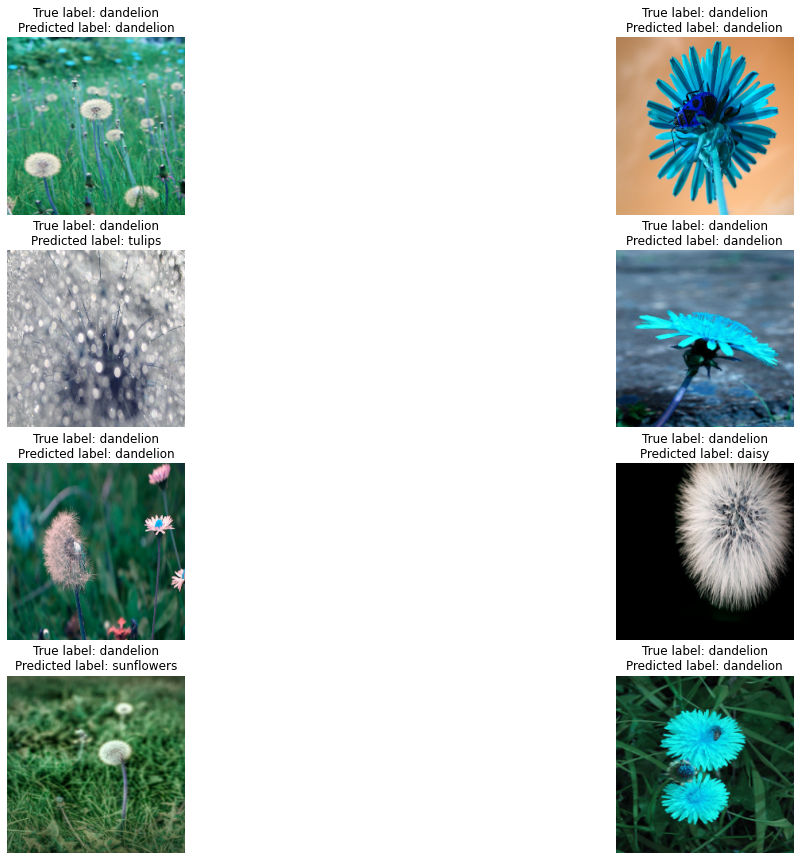

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
images = test_data[200:208]
true_labels = test_labels[200:208]
predicted_labels = rf_preds[200:208]

# Plot images and their predicted and true labels
fig, axs = plt.subplots(4, 2, figsize=(20, 15))
axs = axs.flatten()
for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
    axs[i].imshow(image)
    axs[i].set_title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    axs[i].axis('off')

plt.show()


In [ ]:
import pickle

# specify file path in Google Drive
filepath = '/content/drive/MyDrive/svm_d2'

# create an iterator object with write permission - model.pkl
with open(filepath, 'wb') as f:
    pickle.dump(svm, f)
# specify file path in Google Drive
filepath = '/content/drive/MyDrive/rf_d2'

# create an iterator object with write permission - model.pkl
with open(filepath, 'wb') as f:
    pickle.dump(rf, f)